# Snowworld version 1.3
Presented on DMDU conference november 2018, to showcase the application of DMDU methods for climate change impact studies

Author: Kees van Ginkel

### How does it work?
Snowworld simulates the possible tipping points of a individual ski resort. A tipping point is defined as a bankruptcy (cash < 0 Euro).
All the physics and economics in the model are currently highly stylized.
In it's current form, snowworld can do two types of analysis:

 1) Simulate the financial condition of an individual resort (or compare multiple resorts) under one realization of a climate and determine whether tipping occured.
 
 2) Simulate the financial conditions of one resort under multiple climate condition
 
Snowworld examines the profitability of an individual ski resort. It operates on a yearly timestep. At the end of each year, the amount of money made or lost is determined. This amount depends on the number of good snow conditions N; derived from the rule-of-thumb that N = 100 is required for making some money. 
Each year, the number of good snow conditions is drawn from a random distribution, which depends on the climate. This climate is change over time, depending on the RCP. The number of good snow conditions is also dependent on the elevation of the resort; the higher the resort, the more good snow days.
In it's current form, the number of good snow conditions is only bound by temperature, assuming there is always enough precipitation.

Initialize functions befor running the script

In [1]:
import numpy as np
import random

def generate_climate_stupid(): #Depreciated function
    clim_days_suitable_snow = np.random.normal(110,30,1000) #array with number of suitable snow per year, in this case randomly created: on average 110 days with good snow, stdv = 10; set is 1000 days long 
    return clim_days_suitable_snow

def generate_climate(T,y):
    """
    Generate a climate representative for the situation at 1000 m high:
    
    Arguments:
    T (float) -- the temperature increase in the climate scenario
    y (integer) -- the length of the time series
    
    Returns:
    c (list) -- a list of length y with for each year, the number of days 
    with suitable snow for skiing at 1000 m"""
    #aanname: 100 dagen goed op 1,000 m; op 5,000 meter altijd goed, dus 365, daartussen lineair interpoleren
    #tweede aanname: klimaatverandering omrekenen naar hoogteverschil: 100 m = 0.6 graden; ofwel, 1 graad = (1/0.6)*100 
    c = np.random.normal(100,40,y); #generates a climate with 100 days good snow at 1000 m
    h_eff = (1000-167*T) #als de temperatuur met 1C opwarmt, is het net alsof je ski resort 167 meter omlaag is verplaatst  
    c = c + ((365-100)/(3000-1000))*h_eff-32-100 #simpel lineair equation    
    return c

def T_h(T):
    """
    Converts a change in temperature to a comparable change in elevation
    based on the rule of thumb that 1000 m increase in elevation corresponds
    to a 6 degree Celsius temperature increase
    
    Arguments:
    T (float) -- temperature change in degree C
    
    Returns:
    dh (float) -- corresponding elevation shift in m 
    """
    dh = T * -1000 / 6
    return dh

def h_s(h):
    """
    
    input: h
    output: mean snowday correction at this altitude compared to at 1000 m
    Converts height to snowdays based on these assumptions:
    """
    h1 = 1000 #
    d1 = 100 # 1000 meter matches 100 days
    h2 = 3000
    d2 = 365 # at 3000 meter always snow
    slope = (d2-d1)/(h2-h1)
    d_corr = -slope*(1000-h)
    return d_corr
    
def generate_climate_trend(T,y):
    """
    Generate a climate representative for the situation at 1000 m high:
    input: T the temperature increase in the climate scenario by year y
    input y: the length of the time series
    output c: a list of length y with for each year, the number of days with suitable snow 
    for skiing at 1000 m"""
    c = np.random.normal(90,40,y) #generates a climate with 100 days good snow at 1000 m
    T_trend = np.linspace(0,T,num=y) #create a upward trend in temperature by linear spacing  
    h_eff = (1000+T_h(T_trend)) #als de temperatuur met 1C opwarmt, is het net alsof je ski resort 167 meter omlaag is verplaatst  
    c_out = c + h_s(h_eff)
    return c_out

def resort_snowdays(c,h,A):
    """Generate an array with length l with the number of effective snowdays for resort in given 
    climate time series c with length l, depending on resorts elevation and adaptation opportunities"""
    c = c + h_s(h)
    if A == 1: #if adaptation is on -> 10 extra snowdays
        c = c + 10
    for i in range(0,np.size(c)): # do not allow values < 0 or >200
        if c[i] < 0:
            c[i] = 0
        elif c[i] > 200: #meer dan 200 dagen skiien lijkt niet echt realistisch
            c[i] = 200
    return c        
            

def run_model(snowdays,start_cash,threshold_days):
    """
    Runs the financial development of a ski resort.
    Input: 
    Snowdays = list with the number of suitable snowdays for each year at the resort
    start_cash = cash of the resort in year 0
    threshold_days = the number of suitable snowdays necessary for making a profit
    Returns: cash = a list with the resorts' cash in each year, tip = the year in which the resort went bankrupt 
    """
    #For each year, determine whether a profit was made
    runtime = np.size(snowdays)
    cash = [0] * (runtime+1) #create empty array with the cash
    cash [0] = start_cash
    for t in range(0,runtime):
        cash [t+1] = cash [t] + snowdays[t]*1 - threshold_days #Je verdient precies 1 coin per dag dat je goede sneeuw had
    #    print("In year {0}; startcash = {1:.0f}; profit = {2:.0f}; endcash = {3:.0f}".format(t,cash[t],snowdays[t]*1 - threshold_days,cash[t+1]))
    #Evaluate whether bankruptcy occured
    trouble = np.zeros(runtime) # in principe geen problemen
    for y in range(0,runtime):
        if cash[y] < 0:
            trouble[y] = 1
#    print("In year {}: trouble? {}".format(y,trouble[y]))            
        y = y + 1
    if trouble.any(0): #check whether tipping occurred
        tip = np.min(np.nonzero(trouble)) # in which year does the cash become < 0 for the first time?
    #    print("Tipping occurred in year: {}".format(tip))
    else:
    #    print("No tipping occurred")
        tip = np.NaN
    return cash,tip

def run_multiple(runs,y,start_cash,threshold_days,h_array,T_array):
    """
    run the model multiple times: runs * h * T
    summarize the results and save in the h,T-matrix
    input: 
        runs = the number of times you want to run the model
        y = the length of the climate series you want to create
        threshold_days, start_cash = resort settings
    
    """
    results = np.zeros((len(h_array),len(T_array)))
    a = 0
    for h in h_array:
        b = 0
        for T in T_array:
            tips = [0] * runs #empty array to store results
            for r in range(0,runs):
                climate = generate_climate_trend(T,y)
                res_sd = resort_snowdays(climate,h,0) #todo: adaptation
                cash, tip = run_model(res_sd,start_cash,threshold_days)
                #br = [i for i, j in enumerate(trouble) if j == 1] #array showing years in which bankrupcy occurs
                tips[r] = tip #creates a list with length runs; storing the year in which it tipped
            #Calculate the probability of bankruptcy:
            print("For h = {} and T = {}; tips = {}".format(h,T,tips))
            deaths = len([i for i, j in enumerate(tips) if j <= 100]) #onnodig moeilijk, maar het werkt
            P_survival = deaths / runs
            print("Number of tipping points: {}".format(deaths))
#            print("h = {} and T = {} and P_survival = {} and nr_br = ".format(h,T,P_survival,nr_br))
#            print("x= {} and y = {}".format(x,y))
            results[a,b] = P_survival
            b = b + 1
        a = a + 1
    return results

### Define model settings

In [2]:
#Externalities:
T = 1.5 #degrees of warming in a given RCP
y = 100 #length of the time series in years

### Analysis 1: Run and visualize one realization of the climate, and the associated financial situation of four different ski resorts
#### Run again to see another climate realization
What can you learn from this? 
 - On low altitudes, adaptation measures can help to increase chances on survival, especially on the long term. However, the associated investments in artificial snow making increase the likelihood of tipping on the very short term.
 - On very high altitudes, the model predicts that adaptation measures are not beneficial, because there will be enough natural snow and investing in artificial snow is a waste of money.

Tipping occured in the years: 44, 2, nan, and nan resp.


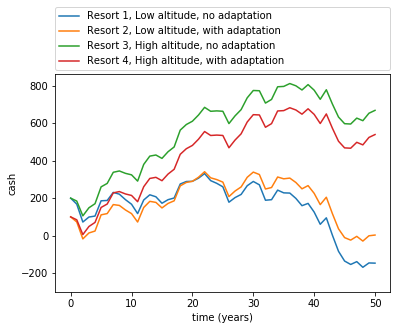

In [6]:
climate = generate_climate_trend(T,y) #generate a climate realisation: (temperature conditions at 1000 m altitude)

#Set properties of the individual resort:
#Resort 1: low-altitude, no adaptation
res1_sd = resort_snowdays(climate,1100,0) #climate, elevation of resort, artifical snowmaking yes/no
res1_cash,res1_tip = run_model(res1_sd,200,100) #res1_sd,start_cash,threshold_days

#Resort 2: low-altidue, with adaptation:
res2_sd = resort_snowdays(climate,1100,1) #they can artificially make more snowdays
res2_cash,res2_tip = run_model(res2_sd,100,105) #they have less cash (large investments), and need more snow days

#Resort 3: high altitude, no adaptation:
res3_sd = resort_snowdays(climate,1300,0) #no artificial snowmaking
res3_cash,res3_tip = run_model(res3_sd,200,110) #they have more cash 

#Resort 4: high altitude, with adaptation:
res4_sd = resort_snowdays(climate,1300,1) # they can make artificial snow
res4_cash,res4_tip = run_model(res4_sd,100,120)  # they have less cash and need more snow to make a profit

print("Tipping occured in the years: {}, {}, {}, and {} resp.".format(res1_tip,res2_tip,res3_tip,res4_tip))

#Visualise the result
import matplotlib.pyplot as plt
x_axis = np.arange(y+1)

fig, ax = plt.subplots()
ax.plot(x_axis, res1_cash, label="Resort 1, Low altitude, no adaptation")
ax.plot(x_axis, res2_cash, label="Resort 2, Low altitude, with adaptation")
ax.plot(x_axis, res3_cash, label="Resort 3, High altitude, no adaptation")
ax.plot(x_axis, res4_cash, label="Resort 4, High altitude, with adaptation")
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
ax.set_ylim(bottom=-300)
ax.set_xlabel("time (years)")
ax.set_ylabel("cash")
plt.show()

In [7]:
#fig.savefig('Snowworld_10_DMDU_resorts_adaptation_not_smart.png',bbox_inches='tight', dpi=300)

### Analysis 2: Simulate behaviour of resorts over multiple climate realizations, and study the results using DMDU principles
This part of the model evaluates the performance of resorts over a 2D-outcome space:

 - h(m): elevation of the resorts
 
 - T(C): temperature increase by 2100
 
Rather than simulating one possible future of the resort (as above) it runs over a predefined number of climate realizations. It then determines how likely the resort is to tip in this future

For h = 1000 and T = 0; tips = [12, 27, 33, 26, nan, 8, 9, 15, 9, 19, 17, 8, 16, 5, 23, 12, 18, 19, 11, 15, 9, 10, 17, 9, 33]
Number of tipping points: 24
For h = 1000 and T = 0.5; tips = [9, 19, 7, 32, 5, 9, 21, 49, 16, 6, 5, 9, 9, 7, 6, 15, 23, 17, 11, 11, 29, 7, 12, 15, 32]
Number of tipping points: 25
For h = 1000 and T = 1; tips = [12, 21, 6, 30, 6, 14, 24, 14, 10, 12, 13, 7, 10, 22, 13, 7, 12, 31, 17, 35, 5, 18, 25, 26, 19]
Number of tipping points: 25
For h = 1000 and T = 1.5; tips = [19, 23, 7, 20, 9, 11, 20, 9, 12, 7, 15, 9, 31, 25, 15, 7, 9, 6, 10, 15, 15, 8, 13, 26, 9]
Number of tipping points: 25
For h = 1000 and T = 2; tips = [17, 7, 21, 12, 12, 12, 7, 13, 8, 11, 11, 10, 14, 10, 14, 20, 7, 17, 32, 13, 6, 6, 18, 14, 17]
Number of tipping points: 25
For h = 1000 and T = 2.5; tips = [11, 6, 8, 17, 4, 13, 24, 13, 13, 17, 11, 31, 14, 7, 8, 17, 10, 26, 12, 13, 17, 6, 18, 3, 9]
Number of tipping points: 25
For h = 1000 and T = 3; tips = [11, 9, 15, 10, 13, 17, 17, 6, 16, 8, 7, 10

For h = 1400 and T = 1; tips = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Number of tipping points: 0
For h = 1400 and T = 1.5; tips = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Number of tipping points: 0
For h = 1400 and T = 2; tips = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Number of tipping points: 0
For h = 1400 and T = 2.5; tips = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Number of tipping points: 0
For h = 1400 and T = 3; tips = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Number of tipping points: 0
For h = 1400 and T = 3.5; tips = [nan, nan, nan, nan, nan, nan, nan, na

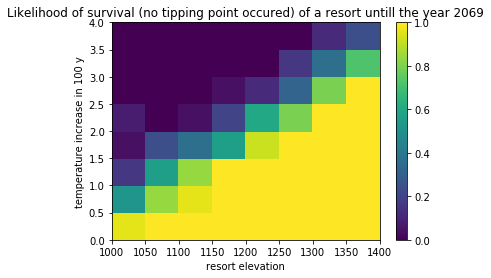

In [5]:
h_array = [1000,1050,1100,1150,1200,1250,1300,1350,1400] #elevation of hypotethical resorts
T_array = [0,0.5,1,1.5,2,2.5,3,3.5,4] #temperature increase per resorts
runs = 25 #number of climate realizations per h-T combination
y = 50 #length of one climate realization 

#all the actual work is done by this function as defined above:
results = run_multiple(runs,y,200,100,h_array,T_array)

#visualize the result
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
p = plt.pcolor(h_array,T_array,results)
cb = fig.colorbar(p)
ax.set_xlabel("resort elevation")
ax.set_ylabel("temperature increase in 100 y")
plt.title("Likelihood of survival (no tipping point occured) of a resort untill the year {}".format(2019+y))
plt.show()

### How could the above help in policy analysis?
Assume that a policy-relevant time-horizon is 50 years: so planning for 2069. Assume that the government thinks the Paris Agreement will be met, so the temperature increase by 2100 will be somewhere between 1.5 and 2.5 degree celsius.

From the above it can be concluded that resorts below 1200 m have very little chances of survival up till 2069, so you probably don't want to invest in them.

### How can this model be further developed?

Physics:

 - explicit modelling of the amount of snowdays; as a function of precipitation AND temperature (not only temperature) -> this would make the results much more realistic, but requires some input data of local conditions.
 - this would require modelling with a daily timestep
 - if the above is implemented, also the benefit from artificial snow making can be made more explicit: if it is cold enough, but no precipitation, this helps. However, if it is too hot, artificial snow making becomes less effective (also when it is far too cold btw). These trade-offs can be nicely modelled.

Economics:
 - Regional economy: study the economics of an area with multiple ski resorts with different altitudes. Compare a region A (some low-lying but vulnerable resorts; but with diverse economy ~ e.g. Steiermark Austria) to region B (economy very much dependent on skiing, but less vulnerable because of higher altitudes)
 - Local economy: for one resort, explore the possibilities of substitution effects; e.g. more opportunities for summer tourism
 - Comparing the European ski resort concept (ski station is a private company, restaurants etc. are owned by other legal entities. The village usually existed before skiing became a major source of income) to the North-American ski resort concept: (purpose-built ski station including all supporting facilities owned by one big investment agency. The village did not exist without the skiing activity.) Interesting trade-offs using agent-based modelling.
 - ...

### Model verification:
To be able to ski, the snow cover should at least be 30 cm, for good conditions 50 cm, and for excellent conditions > 70 cm (Marty, 2013).
Rule-of-thumb: 100 good snow days are required to make a profit, in at least 7 out of 10 seasons to be financially viable (Marty, 2013).
